In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils import data
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from scipy import spatial


import numpy as np

class Gaussain_data(torch.utils.data.Dataset):
    def __init__(self, w_0, margin, size, dim):
        
        # direction = np.random.uniform(size=dim)
        # sigma_mat = np.random.uniform(size=dim**2).reshape((dim, dim))
        # sigma_mat = (sigma_mat.T @ sigma_mat + np.eye(dim)) / dim
        
        ### Try 1
#         direction = np.ones(dim)
        
#         sigma_mat = np.eye(dim)
        
#         input_pos = np.random.multivariate_normal(mu*direction, sigma_mat*(sigma**2), size//2)

#         input_neg = np.random.multivariate_normal(-mu*direction, sigma_mat*(sigma**2), size//2)
        
        
        ### Try 2
#         input_pos = np.concatenate((np.random.multivariate_normal(mu*np.ones(dim), np.eye(dim)*(sigma**2), size//2),
#                         np.random.multivariate_normal(np.zeros(dim), np.eye(dim)*(sigma**2), size//2)), axis=1)

#         input_neg = np.concatenate((np.random.multivariate_normal(-mu*np.ones(dim), np.eye(dim)*(sigma**2), size//2),
#                         np.random.multivariate_normal(np.zeros(dim), np.eye(dim)*(sigma**2), size//2)), axis=1)


        ### Try 3
        
        mu= np.zeros(dim)
        sigma_mat = np.eye(dim)
        
        x = np.random.multivariate_normal(mu, sigma_mat, int(size))
        
        labels = x@w_0 > 0
        
        input_pos = x[np.where(labels==1)[0]]
        input_pos = input_pos/np.expand_dims(np.linalg.norm(input_pos,axis=1),axis=1)
        input_pos += np.expand_dims(margin*w_0,axis=0)
        
        input_neg = x[np.where(labels==0)[0]]
        input_neg = input_neg/np.expand_dims(np.linalg.norm(input_neg,axis=1),axis=1)
        input_neg -= np.expand_dims(margin*w_0,axis=0)
        

        self.p_data  = input_pos.astype(np.float32)
        self.n_data  = input_neg.astype(np.float32)
        self.transform = None
        self.target_transform = None

    def __len__(self):
        return len(self.n_data) + len(self.p_data)


class PosData(torch.utils.data.Dataset):
    def __init__(self, transform=None, target_transform=None, data=None, \
            index=None, data_type=None):
        self.transform = transform
        self.target_transform = target_transform

        self.data=data
        self.targets = np.zeros(data.shape[0], dtype= np.int_)
        self.data_type = data_type
        self.index = index

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        index, img, target = self.index[idx],  self.data[idx], self.targets[idx]

        return index, img, target


class UnlabelData(torch.utils.data.Dataset):
    def __init__(self, transform=None, target_transform=None, pos_data=None, \
            neg_data=None, index=None, data_type=None):
        self.transform = transform
        self.target_transform = target_transform

        self.data=np.concatenate((pos_data, neg_data), axis=0)
        self.true_targets = np.concatenate((np.zeros(pos_data.shape[0],  dtype= np.int_), np.ones(neg_data.shape[0],  dtype= np.int_)), axis=0)
        self.targets = np.ones_like(self.true_targets, dtype= np.int_)

        self.data_type = data_type
        self.index = index

    def __len__(self):
        return len(self.targets)


    def __getitem__(self, idx):

        index, img, target, true_target = self.index[idx],  self.data[idx], self.targets[idx], self.true_targets[idx]

        return index, img, target, true_target    


def get_PUDataSplits(data_obj, pos_size, alpha, beta, data_type=None):
    
    unlabel_size = int((1-beta)*pos_size/beta)

    assert ((pos_size + int(unlabel_size*alpha)) < len(data_obj.p_data)), "Check sizes again"
    assert ((int(unlabel_size*(1-alpha))) < len(data_obj.n_data)), "Check sizes again"

    pos_data = data_obj.p_data[:pos_size]
    unlabel_pos_data = data_obj.p_data[pos_size: pos_size+ int(unlabel_size*alpha)]
    unlabel_neg_data = data_obj.n_data[:int(unlabel_size*(1-alpha))]

    return PosData(transform=data_obj.transform, \
                target_transform=data_obj.target_transform, \
                data=pos_data, index=np.array(range(pos_size)), data_type=data_type), \
            UnlabelData(transform=data_obj.transform, \
                target_transform=data_obj.target_transform, \
                pos_data=unlabel_pos_data, neg_data=unlabel_neg_data, \
                index=np.array(range(unlabel_size)),data_type=data_type)

def get_PNDataSplits(data_obj, pos_size, neg_size, data_type=None):

    unlabel_pos_data = data_obj.p_data[:pos_size]
    unlabel_neg_data = data_obj.n_data[:neg_size]

    return UnlabelData(transform=data_obj.transform, \
                target_transform=data_obj.target_transform, \
                pos_data=unlabel_pos_data, neg_data=unlabel_neg_data, \
                index=np.array(range(pos_size + neg_size)),data_type=data_type)


def get_PU_dataset(w_0, margin, alpha, beta, datasize, dim, batch_size):

    num_points = datasize
    input_size = dim

    gauss_traindata = Gaussain_data(w_0, margin, size=num_points, dim=input_size)
    # print(gauss_traindata.p_data.shape)
    # print(gauss_traindata.n_data.shape)
    gauss_testdata = Gaussain_data(w_0, margin, size=num_points, dim=input_size)
    
    # gauss_traindata = Gaussain_data(mu=mu, sigma=np.sqrt(input_size), size=num_points, dim=input_size)
    # gauss_testdata = Gaussain_data(mu=mu, sigma=np.sqrt(input_size), size=num_points, dim=input_size)

    p_traindata, u_traindata = get_PUDataSplits(gauss_traindata, pos_size=num_points//4, alpha=alpha, beta=beta)
    p_validdata , u_validdata = get_PUDataSplits(gauss_testdata, pos_size=num_points//4, alpha=alpha, beta=beta)


    p_trainloader = torch.utils.data.DataLoader(p_traindata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    u_trainloader = torch.utils.data.DataLoader(u_traindata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    p_validloader = torch.utils.data.DataLoader(p_validdata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    u_validloader = torch.utils.data.DataLoader(u_validdata, batch_size=batch_size, \
        shuffle=True, num_workers=2)

    return p_trainloader, u_trainloader, p_validloader, u_validloader 

def get_PN_dataset(w_0, margin, alpha, beta, datasize, dim, batch_size):

    num_points = datasize
    input_size = dim

    gauss_traindata = Gaussain_data(w_0, margin, size=num_points, dim=input_size)
    gauss_testdata = Gaussain_data(w_0, margin, size=num_points, dim=input_size)
    
    # gauss_traindata = Gaussain_data(mu=mu, sigma=np.sqrt(input_size), size=num_points, dim=input_size)
    # gauss_testdata = Gaussain_data(mu=mu, sigma=np.sqrt(input_size), size=num_points, dim=input_size)

    u_traindata = get_PNDataSplits(gauss_traindata, pos_size=int(num_points//2), neg_size=int(num_points//2))
    u_validdata = get_PNDataSplits(gauss_testdata, pos_size=int(num_points//2), neg_size=int(num_points//2))

    u_trainloader = torch.utils.data.DataLoader(u_traindata, batch_size=batch_size, \
        shuffle=True, num_workers=2)
    u_validloader = torch.utils.data.DataLoader(u_validdata, batch_size=batch_size, \
        shuffle=True, num_workers=2)

    return u_trainloader, u_validloader



In [59]:
def get_gradient(net):
    
    gradient = []
    
    for p in net.parameters(): 
        gradient.append(p.grad.detach().cpu().numpy())
        
        # print(p.grad.detach().cpu().numpy().shape)
        
    gradient = np.column_stack(gradient).ravel()
        
    return gradient


def CVIR_gradient(epoch, net,  p_train, u_train, optimizer, criterion, device, keep_sample=None):

    net.train()

    p_data, u_data = p_train, u_train

    optimizer.zero_grad()

    _, p_inputs, p_targets = p_data
    u_index, u_inputs, u_targets, u_true_targets = u_data
    
    keep_sample = torch.Tensor(keep_sample).to(device)
    u_index = u_index.to(device)

    # u_idx = np.where(keep_sample[u_index.numpy()]==1)[0]
    
    u_idx = (keep_sample[u_index]==1).nonzero().squeeze()
    
    # print(u_idx)

    p_targets = p_targets.to(device)
    u_targets = u_targets.to(device)
    
    p_inputs = p_inputs.to(device)
    u_inputs = u_inputs.to(device)
        
    u_targets = u_targets[u_idx]
    u_inputs = u_inputs[u_idx]

    inputs =  torch.cat((p_inputs, u_inputs), dim=0)
    targets =  torch.cat((p_targets, u_targets), dim=0)

    outputs = net(inputs)

    p_outputs = outputs[:len(p_targets)]
    u_outputs = outputs[len(p_targets):]

    p_loss = criterion(p_outputs, p_targets)
    u_loss = criterion(u_outputs, u_targets)

    loss = (p_loss + u_loss)/2.0

    loss.backward()
    
    gradient = get_gradient(net)
        
    net.zero_grad()
    
    return gradient

def PU_unbiased_gradient(epoch, net,  p_train, u_train, optimizer, criterion, device, alpha, loss_type="sigmoid" ):

    net.train()
    
    p_data, u_data = p_train, u_train
    
    
    if loss_type == "sigmoid":
        criterion = sigmoid_loss
    
    optimizer.zero_grad()

    _, p_inputs, p_targets = p_data
    _, u_inputs, u_targets, u_true_targets = u_data

    p_targets_sub = torch.ones_like(p_targets)
    p_targets, p_targets_sub, u_targets = p_targets.to(device), p_targets_sub.to(device), u_targets.to(device)


    p_inputs , u_inputs = p_inputs.to(device), u_inputs.to(device)
    targets =  torch.cat((p_targets, u_targets), dim=0)
    inputs = torch.cat((p_inputs, u_inputs), axis=0)
    
    
    if loss_type == "sigmoid": 
        outputs = torch.nn.functional.softmax(net(inputs), dim=-1)
    else:         
        outputs = net(inputs)
        
        
    p_outputs = outputs[:len(p_targets)]
    u_outputs = outputs[len(p_targets):]

    loss_pos = criterion(p_outputs, p_targets)
    loss_pos_neg = criterion(p_outputs, p_targets_sub)
    loss_unl = criterion(u_outputs, u_targets)

    loss = alpha * (loss_pos - loss_pos_neg) + loss_unl
    
    
    loss.backward()
    
    gradient = get_gradient(net)
    
    net.zero_grad()
    
    return gradient


def PU_nn_unbiased_gradient(epoch, net,  p_train, u_train, optimizer, criterion, device, alpha, loss_type="sigmoid" ):

    net.train()

    if loss_type=="sigmoid": 
        criterion = sigmoid_loss
    

    p_data, u_data  = p_train, u_train
    optimizer.zero_grad()
    _, p_inputs, p_targets = p_data
    _, u_inputs, u_targets, u_true_targets = u_data

    p_targets_sub = torch.ones_like(p_targets)
    p_targets, p_targets_sub, u_targets = p_targets.to(device), p_targets_sub.to(device), u_targets.to(device)

    p_inputs , u_inputs = p_inputs.to(device), u_inputs.to(device)

    targets =  torch.cat((p_targets, u_targets), dim=0)
    inputs = torch.cat((p_inputs, u_inputs), axis=0)
    
    if loss_type == "sigmoid":
        outputs = torch.nn.functional.softmax(net(inputs), dim=-1)
    else: 
        outputs = net(inputs)
        

    p_outputs = outputs[:len(p_targets)]
    u_outputs = outputs[len(p_targets):]


    loss_pos = criterion(p_outputs, p_targets)
    loss_pos_neg = criterion(p_outputs, p_targets_sub)
    loss_unl = criterion(u_outputs, u_targets)


    if torch.gt((loss_unl - alpha* loss_pos_neg ), 0):
        loss = alpha * (loss_pos - loss_pos_neg) + loss_unl
    else:
        loss = alpha * loss_pos_neg - loss_unl

    loss.backward()
    
    gradient = get_gradient(net)

    net.zero_grad()
    
    return gradient
    
def get_true_gradient(net, p_train, u_train , criterion): 
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    _, p_inputs, p_targets = p_train
    _, inputs, _, targets = u_train
    
    n_idx = (targets==1).nonzero().squeeze()
    n_inputs = inputs[n_idx] 
    
    n_targets = targets[n_idx]
    
    inputs = torch.cat((p_inputs, n_inputs), dim=0)
    targets = torch.cat((p_targets, n_targets), dim=0)
    
    
    inputs , targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)

    
    p_loss = criterion(outputs[:len(p_inputs)], targets[:len(p_inputs)])
    u_loss = criterion(outputs[len(p_inputs):], targets[len(p_inputs):])
    loss = (p_loss + u_loss)/ 2
    
    loss.backward()
    
    gradient = []
    
    for p in net.parameters(): 
        gradient.append(p.grad.detach().cpu().numpy())
        # print(p.grad.detach().cpu().numpy().shape)
                
    net.zero_grad() 
    
    gradient = np.column_stack(gradient).ravel()
    
    return gradient
    
def train_PN(epoch, net, u_train, optimizer, criterion, device, extract_gradient=False):

    net.train()
    train_loss = 0
    correct = 0
    total = 0

    _, inputs, _, targets = u_train
    optimizer.zero_grad()

    inputs , targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    
    if extract_gradient: 
        gradient = get_gradient(net)
        
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)

    correct_preds = predicted.eq(targets).cpu().numpy()
    correct += np.sum(correct_preds)

    if extract_gradient: 
        return 100.*correct/total, loss, gradient
    else: 
        return 100.*correct/total, loss


def train_PU(epoch, net, p_train, u_train, optimizer, criterion, device, extract_gradient=False):
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    p_data, u_data = p_train, u_train
    optimizer.zero_grad()
    _, p_inputs, p_targets = p_data
    _, u_inputs, u_targets, u_true_targets = u_data

    p_targets = p_targets.to(device)
    u_targets = u_targets.to(device)
    
    p_inputs = p_inputs.to(device)
    u_inputs = u_inputs.to(device)
    
    inputs =  torch.cat((p_inputs, u_inputs), dim=0)
    targets =  torch.cat((p_targets, u_targets), dim=0)

    outputs = net(inputs)

    p_outputs = outputs[:len(p_targets)]
    u_outputs = outputs[len(p_targets):]

    p_loss = criterion(p_outputs, p_targets)
    u_loss = criterion(u_outputs, u_targets)
    loss = (p_loss + u_loss)/2.0
    loss.backward()
    
    if extract_gradient: 
        gradient = get_gradient(net)
        
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)

    correct_preds = predicted.eq(targets).cpu().numpy()
    correct += np.sum(correct_preds)
    
    # print(train_loss/ total)

    if extract_gradient: 
        return 100.*correct/total, train_loss, gradient
    else: 
        return 100.*correct/total, train_loss

def train_PU_discard(epoch, net,  p_train, u_train, optimizer, criterion, device, keep_sample=None, extract_gradient=False):

    net.train()
    train_loss = 0
    correct = 0
    total = 0

    p_data, u_data = p_train, u_train

    optimizer.zero_grad()

    _, p_inputs, p_targets = p_data
    u_index, u_inputs, u_targets, u_true_targets = u_data
    
    keep_sample = torch.Tensor(keep_sample).to(device)
    u_index = u_index.to(device)

    # u_idx = np.where(keep_sample[u_index.numpy()]==1)[0]
    
    u_idx = (keep_sample[u_index]==1).nonzero().squeeze()
    
    # print(u_idx)


    p_targets = p_targets.to(device)
    u_targets = u_targets.to(device)
    
    p_inputs = p_inputs.to(device)
    u_inputs = u_inputs.to(device)
        
    u_targets = u_targets[u_idx]
    u_inputs = u_inputs[u_idx]

    inputs =  torch.cat((p_inputs, u_inputs), dim=0)
    targets =  torch.cat((p_targets, u_targets), dim=0)

    outputs = net(inputs)

    p_outputs = outputs[:len(p_targets)]
    u_outputs = outputs[len(p_targets):]

    p_loss = criterion(p_outputs, p_targets)
    u_loss = criterion(u_outputs, u_targets)

    loss = (p_loss + u_loss)/2.0

    loss.backward()
    
    if extract_gradient: 
        gradient = get_gradient(net)
        
    optimizer.step()

    train_loss += loss.item()

    _, predicted = outputs.max(1)
    total += targets.size(0)

    correct_preds = predicted.eq(targets).cpu().numpy()
    correct += np.sum(correct_preds)
    
    if extract_gradient: 
        return 100.*correct/total, train_loss, gradient
    else: 
        return 100.*correct/total, train_loss
    


def rank_inputs(net, u_train, device, alpha, u_size):

    net.eval()
    output_probs = np.zeros(u_size)
    keep_samples = np.ones_like(output_probs)
    true_targets_all = np.zeros(u_size)

    with torch.no_grad():
        idx, inputs, _, true_targets =  u_train
        idx = idx.numpy()

        inputs = inputs.to(device)
        outputs = net(inputs)

        probs  = torch.nn.functional.softmax(outputs, dim=-1)[:,0]
        output_probs[idx] = probs.detach().cpu().numpy().squeeze()
        true_targets_all[idx] = true_targets.numpy().squeeze()

    sorted_idx = np.argsort(output_probs)

    keep_samples[sorted_idx[u_size - int(alpha*u_size):]] = 0
    
    correct_rej = np.mean(true_targets_all[sorted_idx[u_size - int(alpha*u_size):]] == 0)
    
    return keep_samples, correct_rej


def validate(epoch, net, u_valid, device, threshold):

    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    pos_correct = 0
    neg_correct = 0
    pos_total = 0 
    neg_total = 0
    
    with torch.no_grad():
        _, inputs, _, true_targets = u_valid

        inputs , true_targets = inputs.to(device), true_targets.to(device)
        outputs = net(inputs)

        predicted  = torch.nn.functional.softmax(outputs, dim=-1)[:,0] \
                <= torch.tensor([threshold]).to(device)

        total += true_targets.size(0)

        correct_preds = predicted.eq(true_targets).cpu().numpy()
        correct += np.sum(correct_preds)

        pos_idx = torch.where(true_targets == 0)[0]
        neg_idx = torch.where(true_targets == 1)[0]

        # print(pos_idx)
        # print(pos_idx.size(0))

        pos_correct += np.sum(predicted[pos_idx].eq(true_targets[pos_idx]).cpu().numpy())
        neg_correct += np.sum(predicted[neg_idx].eq(true_targets[neg_idx]).cpu().numpy())

        pos_total += pos_idx.size(0)
        neg_total += neg_idx.size(0)
            
    
    return 100.*correct/total, pos_correct/ pos_total, neg_correct/ neg_total

def validate_pos(epoch, net, p_valid, device, threshold):

    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        _, inputs, targets = p_valid

        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)

        predicted  = torch.nn.functional.softmax(outputs, dim=-1)[:,0] \
                <= torch.tensor([threshold]).to(device)


        total += targets.size(0)

        correct_preds = predicted.eq(targets).cpu().numpy()
        correct += np.sum(correct_preds)

    
    return 100.*correct/total

def validate_PU(epoch, net, p_valid, u_valid, device):
    
    net.eval()
    
    train_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        p_data, u_data = p_valid, u_valid

        _, p_inputs, p_targets = p_data
        _, u_inputs, u_targets, u_true_targets = u_data

        p_targets = p_targets.to(device)
        u_targets = u_targets.to(device)
    
        p_inputs = p_inputs.to(device)
        u_inputs = u_inputs.to(device)
        
        inputs =  torch.cat((p_inputs, u_inputs), dim=0)
        targets =  torch.cat((p_targets, u_targets), dim=0)

        outputs = net(inputs)

        _, predicted = outputs.max(1)
        total += targets.size(0)

        correct_preds = predicted.eq(targets).cpu().numpy()
        correct += np.sum(correct_preds)
    
    # print(train_loss/ total)

    return 100.*correct/total

def sigmoid_loss(out, y):
    # loss = torch.gather(out, dim=1, index=y).sum()
    loss = out.gather(1, 1- y.unsqueeze(1)).mean()
    return loss


def train_PU_unbiased(epoch, net,  p_train, u_train, optimizer, criterion, device, alpha, loss_type="sigmoid", extract_gradient=False):

    net.train()
    correct = 0
    total = 0
    
    train_loss = 0
    
    p_data, u_data = p_train, u_train
    
    
    if loss_type == "sigmoid":
        criterion = sigmoid_loss
    
    optimizer.zero_grad()

    _, p_inputs, p_targets = p_data
    _, u_inputs, u_targets, u_true_targets = u_data

    p_targets_sub = torch.ones_like(p_targets)
    p_targets, p_targets_sub, u_targets = p_targets.to(device), p_targets_sub.to(device), u_targets.to(device)


    p_inputs , u_inputs = p_inputs.to(device), u_inputs.to(device)
    targets =  torch.cat((p_targets, u_targets), dim=0)
    inputs = torch.cat((p_inputs, u_inputs), axis=0)
    
    
    if loss_type == "sigmoid": 
        outputs = torch.nn.functional.softmax(net(inputs), dim=-1)
    else:         
        outputs = net(inputs)
        
        
    p_outputs = outputs[:len(p_targets)]
    u_outputs = outputs[len(p_targets):]

    loss_pos = criterion(p_outputs, p_targets)
    loss_pos_neg = criterion(p_outputs, p_targets_sub)
    loss_unl = criterion(u_outputs, u_targets)

    # loss = alpha * (loss_pos) + loss_unl
    loss = alpha * (loss_pos - loss_pos_neg) + loss_unl
    
    # print(loss_pos) 
    # print(loss_pos_neg) 
    # print(loss_unl)
    
    loss.backward()
    
    if extract_gradient: 
        gradient = get_gradient(net)
        
    optimizer.step()
    
    train_loss += loss.item()
    

    _, predicted = outputs.max(1)
    total += targets.size(0)

    correct_preds = predicted.eq(targets).cpu().numpy()
    correct += np.sum(correct_preds)
    
    if extract_gradient: 
        return 100.*correct/total, train_loss, gradient
    else: 
        return 100.*correct/total, train_loss
    


def train_PU_nn_unbiased(epoch, net,  p_train, u_train, optimizer, criterion, device, alpha, loss_type="sigmoid", extract_gradient=False):

    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    if loss_type=="sigmoid": 
        criterion = sigmoid_loss
    

    p_data, u_data  = p_train, u_train
    optimizer.zero_grad()
    _, p_inputs, p_targets = p_data
    _, u_inputs, u_targets, u_true_targets = u_data

    p_targets_sub = torch.ones_like(p_targets)
    p_targets, p_targets_sub, u_targets = p_targets.to(device), p_targets_sub.to(device), u_targets.to(device)

    p_inputs , u_inputs = p_inputs.to(device), u_inputs.to(device)

    targets =  torch.cat((p_targets, u_targets), dim=0)
    inputs = torch.cat((p_inputs, u_inputs), axis=0)
    
    if loss_type == "sigmoid":
        outputs = torch.nn.functional.softmax(net(inputs), dim=-1)
    else: 
        outputs = net(inputs)
        

    p_outputs = outputs[:len(p_targets)]
    u_outputs = outputs[len(p_targets):]


    loss_pos = criterion(p_outputs, p_targets)
    loss_pos_neg = criterion(p_outputs, p_targets_sub)
    loss_unl = criterion(u_outputs, u_targets)


    if torch.gt((loss_unl - alpha* loss_pos_neg ), 0):
        loss = alpha * (loss_pos - loss_pos_neg) + loss_unl
    else:
        loss = alpha * loss_pos_neg - loss_unl

    loss.backward()
    
    if extract_gradient: 
        gradient = get_gradient(net)

    optimizer.step()

    train_loss += loss.item()

    _, predicted = outputs.max(1)
    total += targets.size(0)

    correct_preds = predicted.eq(targets).cpu().numpy()
    correct += np.sum(correct_preds)
    
    
    if extract_gradient: 
        return 100.*correct/total, train_loss, gradient
    else: 
        return 100.*correct/total, train_loss
    

In [15]:
    
device = "cuda"

input_dim = 1000
datasize = 1000
alpha = 0.5 
beta = 1.0/2

batch_size = datasize//4

margin = 0.04
w_0 = np.random.uniform(size = input_dim) - 0.5 
# w_0 = np.concatenate((w_0)
w_0 = w_0 / np.linalg.norm(w_0)
        
        
p_trainloader, u_trainloader, _, _ = get_PU_dataset(w_0, margin, alpha, beta, datasize, input_dim, batch_size)
_, _, p_validloader, u_validloader = get_PU_dataset(w_0, margin, alpha, beta, datasize*20, input_dim, batch_size*20)

p_train_idx, p_train_data, p_train_targets = next(iter(p_trainloader))
u_train_idx, u_train_data, u_train_targets, u_train_true_targets = next(iter(u_trainloader))

p_valid_idx, p_valid_data, p_valid_targets = next(iter(p_validloader))
u_valid_idx, u_valid_data, u_valid_targets, u_valid_true_targets = next(iter(u_validloader))


p_train = (p_train_idx, p_train_data, p_train_targets)
u_train = (u_train_idx, u_train_data, u_train_targets, u_train_true_targets)

p_valid = (p_valid_idx, p_valid_data, p_valid_targets)
u_valid = (u_valid_idx, u_valid_data, u_valid_targets, u_valid_true_targets)


nnPU = []
uPU = []
PvU = []
CVIR_scratch = []
CVIR_init = []



In [60]:
correct_rej_scratch  = []
correct_rej_init  = []

In [85]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
CVIR_gradient_alignment = []
uPU_gradient_alignment = []

true_grad_norm = []

# seed_everything(0)

net = nn.Sequential(nn.Flatten(), nn.Linear(input_dim, 2, bias=True) ) 
# net = nn.Sequential(nn.Linear(input_dim, 5000, bias=True), nn.ReLU() , nn.Linear(5000, 2, bias=True)) 

# net[0].weight.requires_grad = False
# net[0].bias.requires_grad = False


net = net.to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=.0001)
optimizer = optim.SGD(net.parameters(), lr=.1, momentum= 0.9, weight_decay=0.0)

In [87]:
epochs = 5000

keep_samples = np.ones(datasize//4)
loss = 0.0 
valid_pu_acc = 0.0 

true_gradient = None
gradient = None


for epoch in range(epochs): 
    
    # true_gradient = get_true_gradient(net, p_train, u_train, criterion)
    
#     keep_valid_samples = rank_inputs(net, u_train, device, alpha , u_size=datasize//4)
#     gradient = CVIR_gradient(epoch, net,  p_train, u_train, optimizer, criterion, device, keep_sample=keep_valid_samples)
    
    # gradient = PU_unbiased_gradient(epoch, net,  p_train, u_train, optimizer, criterion, device, alpha, "sigmoid")
    # gradient = PU_nn_unbiased_gradient(epoch, net,  p_valid, u_valid, optimizer, criterion, device, alpha, "logistic")
    
    # train_acc, loss = train_PU(epoch, net, p_train, u_train, optimizer, criterion, device)
    
    # train_acc, loss = train_PU_unbiased(epoch, net,  p_train, u_train, optimizer, criterion, device, alpha, "sigmoid")
    # train_acc, loss = train_PU_nn_unbiased(epoch, net,  p_train, u_train, optimizer, criterion, device, alpha, "sigmoid")
    
    train_acc, loss= train_PN(epoch, net, u_train, optimizer, criterion, device, extract_gradient=False)
    # train_acc, loss, gradient = train_PN(epoch, net, u_train, optimizer, criterion, device, extract_gradient=True)
    
    # train_acc, loss, gradient = train_PU_discard(epoch, net, p_train, u_train, optimizer, criterion, device, keep_sample=keep_samples, extract_gradient=True)
    # train_acc, loss = train_PU_discard(epoch, net, p_train, u_train, optimizer, criterion, device, keep_sample=keep_samples, extract_gradient=False)
    # keep_samples, correct_rej = rank_inputs(net, u_train, device, alpha , u_size=datasize//4)
    
    valid_acc, pos_valid_acc, neg_valid_acc = validate(epoch, net, u_valid, device, 0.5)
    # valid_pu_acc = validate_PU(epoch, net, p_valid, u_valid, device)
    # train_acc = validate_PU(epoch, net, p_train, u_train, device)
    # train_acc, pos_train_acc, neg_train_acc = validate(epoch, net, u_trainloader, device, 0.5)
    # pos_train_acc_2 = validate_pos(epoch, net, p_trainloader, device, 0.5)
    
    if epoch %100 == 0:
        # print(net[1].bias)
        print(f"Epoch: {epoch:.2f} Train Accuracy: {train_acc:.2f}, Train loss: {loss:.2f},  PU Valid accuracy: {valid_pu_acc:.2f}, Valid Accuracy: {valid_acc:.2f}")
    # print(f"\t \t Valid unlabeled pos acc: {pos_valid_acc} Valid unlabeled neg acc: {neg_valid_acc}  ")    
    # print(f"\t \t Train unlabeled pos acc: {pos_train_acc} Train unlabeled neg acc: {neg_train_acc} Train pos acc: {pos_train_acc_2} ")
    
    # print(gradient.shape)
    
    # CVIR_gradient_alignment.append(1 - spatial.distance.cosine(gradient, true_gradient))
    # true_grad_norm.append(np.linalg.norm(true_gradient))
    
    # PvU.append(valid_acc)
    # uPU.append(valid_acc)    
    # nnPU.append(valid_acc)
    # CVIR_scratch.append(valid_acc)
    # CVIR_init.append(valid_acc) 
    PvN.append(valid_acc) 
    
    # correct_rej_scratch.append(correct_rej)
    # correct_rej_init.append(correct_rej)    

Epoch: 0.00 Train Accuracy: 56.40, Train loss: 0.69,  PU Valid accuracy: 0.00, Valid Accuracy: 53.30
Epoch: 100.00 Train Accuracy: 99.60, Train loss: 0.43,  PU Valid accuracy: 0.00, Valid Accuracy: 97.08
Epoch: 200.00 Train Accuracy: 100.00, Train loss: 0.30,  PU Valid accuracy: 0.00, Valid Accuracy: 97.20
Epoch: 300.00 Train Accuracy: 100.00, Train loss: 0.23,  PU Valid accuracy: 0.00, Valid Accuracy: 97.28
Epoch: 400.00 Train Accuracy: 100.00, Train loss: 0.18,  PU Valid accuracy: 0.00, Valid Accuracy: 97.32
Epoch: 500.00 Train Accuracy: 100.00, Train loss: 0.15,  PU Valid accuracy: 0.00, Valid Accuracy: 97.34
Epoch: 600.00 Train Accuracy: 100.00, Train loss: 0.13,  PU Valid accuracy: 0.00, Valid Accuracy: 97.32
Epoch: 700.00 Train Accuracy: 100.00, Train loss: 0.11,  PU Valid accuracy: 0.00, Valid Accuracy: 97.38
Epoch: 800.00 Train Accuracy: 100.00, Train loss: 0.10,  PU Valid accuracy: 0.00, Valid Accuracy: 97.38
Epoch: 900.00 Train Accuracy: 100.00, Train loss: 0.09,  PU Valid ac

In [84]:
# correct_rej_scratch

PvN = []

<ipython-input-90-79be9021ee1b>:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


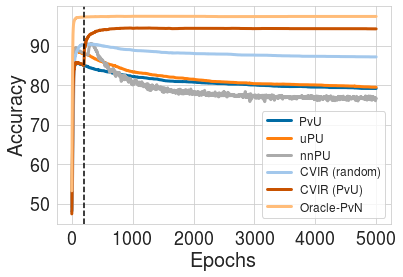

In [90]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.signal import savgol_filter

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

# sns.set_style("whitegrid")

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
             
# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

markers = ['+', 'x', '.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '|', '_', 'P', 'X', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ]

patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.', '/')


fig,ax = plt.subplots()

l=3.0
fc=20

ax.plot(range(5000), PvU, label = "PvU", linewidth=l, color=tableau20blind[0]) 
ax.plot(range(5000), uPU, label = "uPU", linewidth=l, color=tableau20blind[1]) 
ax.plot(range(5000), nnPU_filtered, label = "nnPU", linewidth=l, color=tableau20blind[2]) 
ax.plot(range(5000), CVIR_scratch, label = "CVIR (random)", linewidth=l, color=tableau20blind[7]) 
ax.plot(range(5000), CVIR_init, label = "CVIR (PvU)", linewidth=l, color=tableau20blind[5]) 
ax.plot(range(5000), PvN, label = "Oracle-PvN ", linewidth=l, color=tableau20blind[8]) 
        
        
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.axvline(x=200, linestyle='--', color='black', linewidth=l/2)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_xlabel('Epochs',fontsize=20)
plt.legend(prop={"size":18}, fontsize=20)
ax.legend(fontsize=12)

ax.grid(b=True)


plt.savefig("figures/toy_acc-2.png" ,transparent=True,bbox_inches='tight')
# plt.clf()


<ipython-input-82-2b6ea886c95b>:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


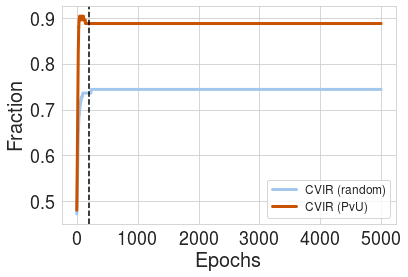

In [82]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.signal import savgol_filter

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

# sns.set_style("whitegrid")

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
             
# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

markers = ['+', 'x', '.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '|', '_', 'P', 'X', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ]

patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.', '/')


fig,ax = plt.subplots()

l=3.0
fc=20

# ax.plot(range(5000), PvU, label = "PvU", linewidth=l, color=tableau20blind[0]) 
# ax.plot(range(5000), uPU, label = "uPU", linewidth=l, color=tableau20blind[1]) 
# ax.plot(range(5000), nnPU_filtered, label = "nnPU", linewidth=l, color=tableau20blind[2]) 
ax.plot(range(5000), correct_rej_scratch, label = "CVIR (random)", linewidth=l, color=tableau20blind[7]) 
ax.plot(range(5000), correct_rej_init[:5000], label = "CVIR (PvU)", linewidth=l, color=tableau20blind[5]) 
        
        
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.axvline(x=200, linestyle='--', color='black', linewidth=l/2)
ax.set_ylabel('Fraction',fontsize=20)
ax.set_xlabel('Epochs',fontsize=20)
plt.legend(prop={"size":18}, fontsize=20)
ax.legend(fontsize=12)

ax.grid(b=True)


plt.savefig("figures/toy_rej.png" ,transparent=True,bbox_inches='tight')
# plt.clf()


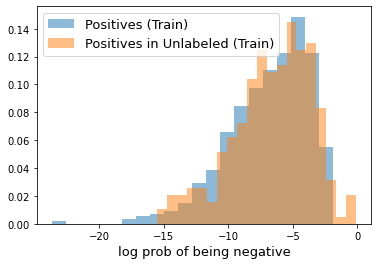

In [169]:
import matplotlib.pyplot as plt 


pos_arr = []
pos_unlabeled_arr = []

net.eval()
    
train_loss = 0
correct = 0
total = 0

with torch.no_grad():
    p_data, u_data = p_train, u_train

    _, p_inputs, p_targets = p_data
    _, u_inputs, u_targets, u_true_targets = u_data

    p_targets = p_targets.to(device)
    u_targets = u_targets.to(device)

    p_inputs = p_inputs.to(device)
    u_inputs = u_inputs.to(device)

    inputs =  torch.cat((p_inputs, u_inputs), dim=0)
    targets =  torch.cat((p_targets, u_targets), dim=0)

    outputs = net(inputs)

    probs = torch.nn.functional.softmax(outputs, dim=-1)[:,1]
    
    pos_arr.extend(probs[:len(p_targets)].cpu().numpy())
    pos_unlabeled_arr.extend(probs[len(p_targets):][np.where(u_true_targets==0)[0]].cpu().numpy())
    
plt.hist(np.log(np.array(pos_arr) + 1e-30), bins = 20,alpha = 0.5, density=True, label="Positives (Train)")
plt.hist(np.log(np.array(pos_unlabeled_arr)+ 1e-30),  bins = 20, alpha=0.5, density=True, label="Positives in Unlabeled (Train)")

plt.xlabel("log prob of being negative", fontsize=13)
plt.legend(fontsize=13)

# plt.savefig("histogram_log_prob.pdf", bbox_inches='tight', transparent=True)